In [1]:
!pip install lime tensorflow
!pip install transformers==2.1

     |████████████████████████████████| 276kB 11.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=cdc95e2d25f0549cd6691edfdca88d9c7e8ce036572d28ef18f4c3da69aea015
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 317kB 11.2MB/s 
     |████████████████████████████████| 890kB 20.9MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 1.1MB 35.8MB/s 
     |████████████████████████████████| 7.0MB 37.5MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a335460a93d764fcdd06768fcba15c5551073346d3ca72a35cf66916da355319
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for boto3: filename=boto3-1.16.33-py2.py3-non

In [2]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for explainer
from lime import lime_text
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

from sklearn import model_selection, metrics
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

        Unnamed: 0  ...                cat
0             1364  ...               TECH
1            84659  ...  POLITICS & WORLDS
2           145466  ...           BUSINESS
3            46639  ...           BUSINESS
4           156821  ...      ENTERTAINMENT
...            ...  ...                ...
163851       83617  ...  POLITICS & WORLDS
163852       79073  ...               TECH
163853       46650  ...  POLITICS & WORLDS
163854       40168  ...              SPORT
163855       69112  ...              SPORT

[163856 rows x 3 columns]


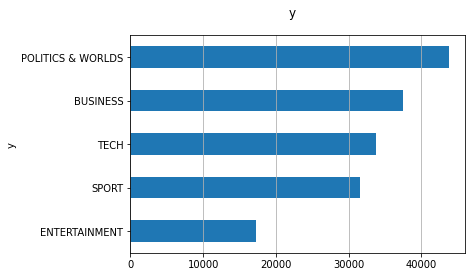

In [ ]:
dtf = pd.read_csv('/content/drive/MyDrive/final_dataset.csv')
dtf = dtf.sample(frac=1).reset_index(drop=True)
dtf = dtf.rename(columns={"cat":"y"})

fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12) 
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    text = " ".join(lst_text)
    return text
def create_feature_matrix(corpus):
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    maxlen = 150
    maxqnans = np.int((maxlen-20)/2)
    corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]
    masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    segments = [] 
    for seq in txt2seq:
        temp, i = [], 0
        for token in seq.split(" "):
            temp.append(i)
            if token == "[SEP]":
                i += 1
        segments.append(temp)
    feature_matrix = [np.asarray(idx, dtype='int32'), 
                      np.asarray(masks, dtype='int32'), 
                      np.asarray(segments, dtype='int32')]
    return feature_matrix

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords
dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.1)
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [ ]:
X_train = create_feature_matrix(dtf_train['text_clean'])

100%|██████████| 231508/231508 [00:00<00:00, 919797.83B/s]


In [ ]:
idx = layers.Input((150), dtype="int32", name="input_idx")
masks = layers.Input((150), dtype="int32", name="input_masks")
segments = layers.Input((150), dtype="int32", name="input_segments")
nlp = transformers.TFBertModel.from_pretrained("bert-base-uncased")
bert_out, _ = nlp.bert([idx, masks, segments])
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
model = models.Model([idx, masks, segments], y_out)
for layer in model.layers[:4]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

100%|██████████| 536063208/536063208 [00:16<00:00, 32453094.64B/s]


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          ((None, 150, 768), ( 109482240   input_idx[0][0]                  
                                                                 input_masks[0][0]     

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])


In [ ]:
training = model.fit(X_train, y_train, batch_size=64, epochs=15, shuffle=True, verbose=1, validation_split=0.3)
model.save('/content/drive/MyDrive/DATN/Models/Bert_epoch15')

Epoch 1/15
1613/1613 [==============================] - 1651s 1s/step - loss: 0.5058 - accuracy: 0.8264 - val_loss: 0.4131 - val_accuracy: 0.8550
Epoch 2/15
1613/1613 [==============================] - 1652s 1s/step - loss: 0.4333 - accuracy: 0.8476 - val_loss: 0.3936 - val_accuracy: 0.8609
Epoch 3/15
1613/1613 [==============================] - 1652s 1s/step - loss: 0.4138 - accuracy: 0.8522 - val_loss: 0.3826 - val_accuracy: 0.8642
Epoch 4/15
1613/1613 [==============================] - 1651s 1s/step - loss: 0.4021 - accuracy: 0.8560 - val_loss: 0.3779 - val_accuracy: 0.8656
Epoch 5/15
1613/1613 [==============================] - 1653s 1s/step - loss: 0.3966 - accuracy: 0.8585 - val_loss: 0.3762 - val_accuracy: 0.8661
Epoch 6/15
1613/1613 [==============================] - 1653s 1s/step - loss: 0.3882 - accuracy: 0.8615 - val_loss: 0.3633 - val_accuracy: 0.8704
Epoch 7/15
1613/1613 [==============================] - 1652s 1s/step - loss: 0.3852 - accuracy: 0.8612 - val_loss: 0.3727 -

In [ ]:
X_test = create_feature_matrix(dtf_test['text_clean'])

In [3]:
new_model = models.load_model('/content/drive/MyDrive/DATN/Models/Bert_epoch15')

In [ ]:

predicted_prob = new_model.predict(X_test, batch_size = 64)
predicted = []
i = 0
while (i < len(predicted_prob)):
    try:
        result = {0: 'BUSINESS', 1: 'ENTERTAINMENT', 2: 'POLITICS & WORLDS', 3: 'SPORT', 4: 'TECH'}[np.argmax(predicted_prob[i])]
        predicted.append(result)
    except:
        print(i)
        predicted.append('UNKNOWN')
    i = i + 1
predicted = pd.DataFrame(predicted)
frame = {'text': dtf_test['text'], 'prediction': predicted[0].values }
d_t_f = pd.DataFrame(frame)

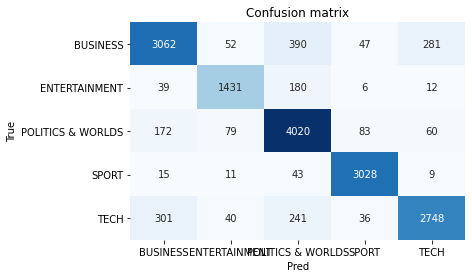

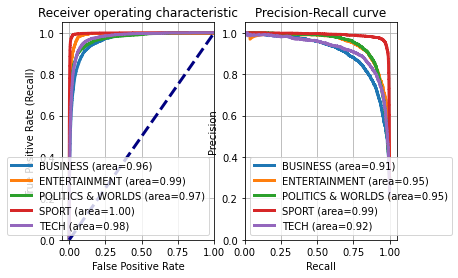

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()